In [8]:
import csv
import pandas as pd
from collections import defaultdict

# File paths
wordcounts_file = 'word_counts.txt'
replacement_words_file = 'replacement_words.csv'
output_lift_values = 'Lift_Values.csv'
output_lift_matrix = 'Lift_Matrix.csv'
input_file = 'replacement_sample_data.csv'
pair_keys_file = 'edmunds_pair_keys.txt'

import re
import string
from nltk.corpus import stopwords

# Download stopwords from nltk if not already done
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans the input text by removing punctuation, converting to lowercase, and removing stopwords.
    """
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    
    return cleaned_words  # Return the cleaned words as a list

# Step 1: Load and sort word counts
def load_word_counts(filename):
    """
    Loads word counts from a text file and returns a dictionary of word:count pairs.
    Skips any lines that don't have valid counts.
    """
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                # Skip lines with invalid data (like headers or incorrectly formatted lines)
                print(f"Skipping invalid line: {line.strip()}")
    # Sort word counts by frequency (highest to lowest)
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_word_counts


# Step 2: Load replacement words (brands and models)
def load_replacement_words(filename):
    """
    Loads replacement words from a CSV file, returns a set of valid brands,
    and excludes the words 'car' and 'seat'.
    """
    df = pd.read_csv(filename)
    valid_brands = set(df['Brand'].unique())  # Get unique brands
    # Exclude non car brands from the file
    valid_brands.discard('car')
    valid_brands.discard('seat')
    valid_brands.discard('problem')
    valid_brands.discard('sedan')
    return valid_brands


# Step 3: Get top 10 brands by word count
def get_top_brands(word_counts, valid_brands):
    """
    Matches the words in word_counts to valid brands and returns up to the top 10 brands by count.
    Ensures that only car brands (from valid_brands) are included, ignoring non-brand words.
    Stops either when 10 brands are found or when the end of the word_counts list is reached.
    """
    top_brands = []
    for word, count in word_counts.items():
        # Only add the word if it's in the valid_brands set
        if word in valid_brands:
            top_brands.append(word)
        # Stop if we have found 10 brands or processed all words
        if len(top_brands) == 10:
            break
    
    return top_brands

# Step 4: Process the input CSV file to extract posts
def process_input_file(input_filename):
    """
    Processes the input CSV file to extract and clean posts. Each post is
    tokenized and cleaned of punctuation and stopwords, and stored in a list.
    """
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming the text is in the first column
            posts.append(post)
    return posts

# Step 5: Calculate word pair lift values
def calculate_lift_for_brands(posts, top_brands):
    """
    Calculates lift values for the top brands.
    """
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count frequencies of brands and co-occurrences
    for post in posts:
        unique_words = set(post)
        for word in unique_words:
            if word in top_brands:
                word_frequency[word] += 1
        for word1 in unique_words:
            for word2 in unique_words:
                if word1 in top_brands and word2 in top_brands and word1 != word2:
                    word_pair_frequency[word1][word2] += 1

    # Calculate lift values and store them in a DataFrame
    df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])
    for word1 in top_brands:
        for word2 in top_brands:
            if word1 != word2:
                p_word1_and_word2 = word_pair_frequency[word1][word2] / total_posts
                p_word1 = word_frequency[word1] / total_posts
                p_word2 = word_frequency[word2] / total_posts
                if p_word1 > 0 and p_word2 > 0:
                    lift_value = p_word1_and_word2 / (p_word1 * p_word2)
                    df_lift = df_lift.append({'word1': word1, 'word2': word2, 'lift_value': lift_value}, ignore_index=True)
    
    return df_lift

# Step 6: Save results
def save_results(df_lift):
    """
    Saves the lift values and matrix to CSV files.
    """
    df_lift.to_csv(output_lift_values, index=False)
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix.to_csv(output_lift_matrix)

# Main script

# Load word counts and replacement words
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)

# Get the top 10 brands by word count
top_brands = get_top_brands(word_counts, valid_brands)
print("Top 10 brands:", top_brands)

# Process the input file and calculate lift values
posts = process_input_file(input_file)
df_lift = calculate_lift_for_brands(posts, top_brands)

# Save results
save_results(df_lift)



[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


Skipping invalid line: word,count
Top 10 brands: ['bmw', 'acura', 'infiniti', 'audi', 'lexus', 'honda', 'toyota', 'nissan', 'volkswagen', 'ford']


/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_80996/550718997.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lift = df_lift.append({'word1': word1, 'word2': word2, 'lift_value': lift_value}, ignore_index=True)
/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_80996/550718997.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lift = df_lift.append({'word1': word1, 'word2': word2, 'lift_value': lift_value}, ignore_index=True)
/var/folders/m2/b8l4_05d1p39hmx00f4y_czr0000gn/T/ipykernel_80996/550718997.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_lift = df_lift.append({'word1': word1, 'word2': word2, 'lift_value': lift_value}, ignore_index=True)
/var/folders/m2/b8l4_05d1p39hmx00f

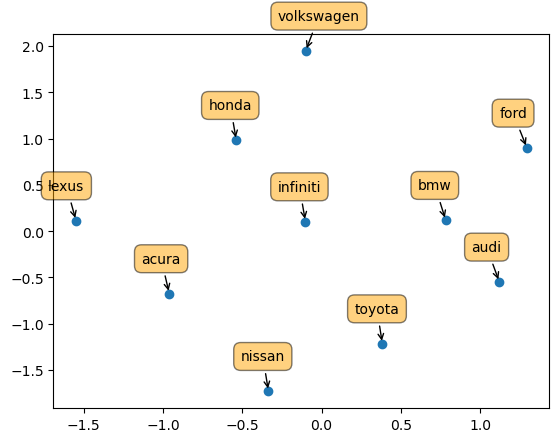

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Pivot df_lift to create a matrix for dissimilarity
dissimilarity_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')

# Ensure the diagonal is filled with zeros
np.fill_diagonal(dissimilarity_matrix.values, 0)

# Proceed with MDS
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
                   random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

# Plotting
plt.subplots_adjust(bottom=0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker='o')
for label, x, y in zip(top_brands, coords[:, 0], coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.show()
